# Imports

In [32]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Classificazione

#### Distinguiamo due diversi approcci per la classificazione: online e offline. Nell'approccio online si utilizzano feature collezionabili solo tramite un dataset che fornisce dati in tempo reale come i diversi livelli di pressione a ogni istante temporale, al contrario in offline si lavora soltanto con rappresentazioni grafiche di testo senza basarsi su dati estranei al disegno stesso.

## Approccio offline tramite Transfer Learning

### Split del dataset ricavato tramite la VGG16

In [33]:
features_df = pd.DataFrame()
features_df = pd.read_csv("CNNFeatureExtraction.csv")

train, test = train_test_split(features_df, test_size=20)

y = features_df['diag']

trainY = train["diag"]
trainX = train.drop(["diag"], axis=1)

testY = test["diag"]
testX = test.drop(["diag"], axis=1)

### Distribuzione della feature obiettivo

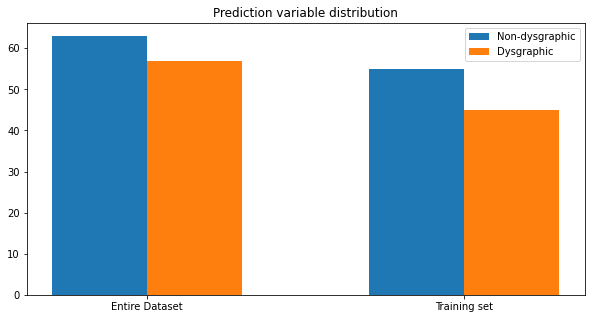

In [34]:
# Plotting the prediction variable distribution in both whole dataset and traning set

# Specify the values of blue bars (height)
blue_bar = (y.value_counts()[0], trainY.value_counts()[0])
# Specify the values of orange bars (height)
orange_bar = (y.value_counts()[1], trainY.value_counts()[1])


ind = np.arange(2)
plt.figure(figsize=(10,5))
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Non-dysgraphic')
plt.bar(ind + width, orange_bar, width, label='Dysgraphic')
plt.xlabel('')
plt.ylabel('')
plt.title('Prediction variable distribution')

# xticks()
plt.xticks(ind + width / 2, ('Entire Dataset', 'Training set'))

# Finding the best position for legends and putting it
plt.legend(loc='best')

plt.show()

### Ridge Classifier

In [35]:
model = RidgeClassifier(alpha=100)
model.fit(trainX, trainY)

print(model.score(testX,testY))

0.85


### Logistic Regression

In [36]:
logModel = LogisticRegression()
logModel.fit(trainX, trainY)

print(logModel.score(testX,testY))

0.95


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Decision Tree Classifier

In [37]:
tree = DecisionTreeClassifier()
tree.fit(trainX, trainY)

print(tree.score(testX,testY))

0.65


## Approccio online

### Split del dataset

In [38]:
# Drop ID feature
users_df = pd.read_csv('augmentedDataset.csv')
users_df.drop("ID", axis=1, inplace=True)

X = users_df.drop('diag', axis=1)
y = users_df['diag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [39]:
# Make all values numeric
X_train = X_train.apply(pd.to_numeric)
y_train = y_train.apply(pd.to_numeric)

X_test = X_test.apply(pd.to_numeric)
y_test = y_test.apply(pd.to_numeric)

### Distribuzione della feature obiettivo

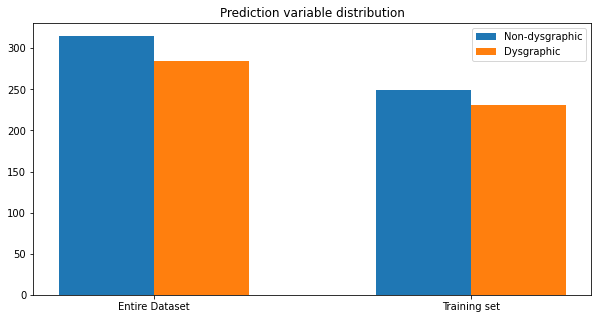

In [40]:
# Plotting the prediction variable distribution in both whole dataset and traning set

# Specify the values of blue bars (height)
blue_bar = (y.value_counts()[0], y_train.value_counts()[0])
# Specify the values of orange bars (height)
orange_bar = (y.value_counts()[1], y_train.value_counts()[1])


ind = np.arange(2)
plt.figure(figsize=(10,5))
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Non-dysgraphic')
plt.bar(ind + width, orange_bar, width, label='Dysgraphic')
plt.xlabel('')
plt.ylabel('')
plt.title('Prediction variable distribution')

# xticks()
plt.xticks(ind + width / 2, ('Entire Dataset', 'Training set'))

# Finding the best position for legends and putting it
plt.legend(loc='best')

plt.show()

#### Se ci fosse troppo divario tra persone disgrafiche e non, sarebbe un problema.

### Decision Tree Classifier

In [41]:
DCclassifier = DecisionTreeClassifier(criterion="entropy", random_state=0)
DCclassifier.fit(X_train, y_train)

y_pred = DCclassifier.predict(X_test)

In [42]:
# Accuracy
testScore = (DCclassifier.score(X_test, y_test))*100

print("ACCURACY ON TEST SET: {:.1f}%".format(testScore))

ACCURACY ON TEST SET: 100.0%


In [43]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        54

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



#### Matrice di confusione

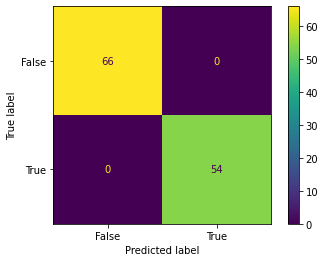

In [44]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### 5-Fold Cross Validation con Random Forest Classifier

In [45]:
# 5-Fold cross validation function
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [46]:
# Function to create Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

#### Prediction

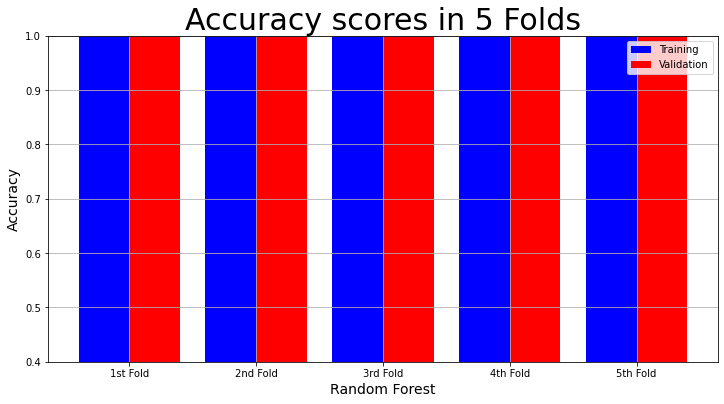

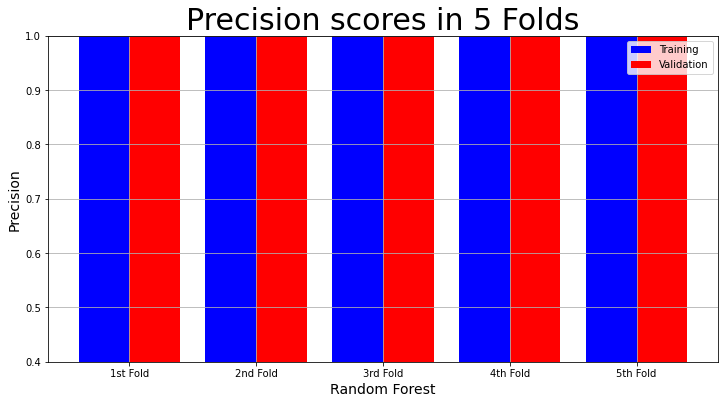

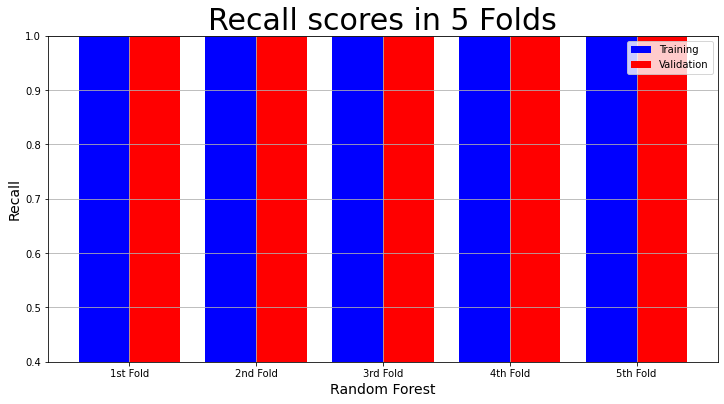

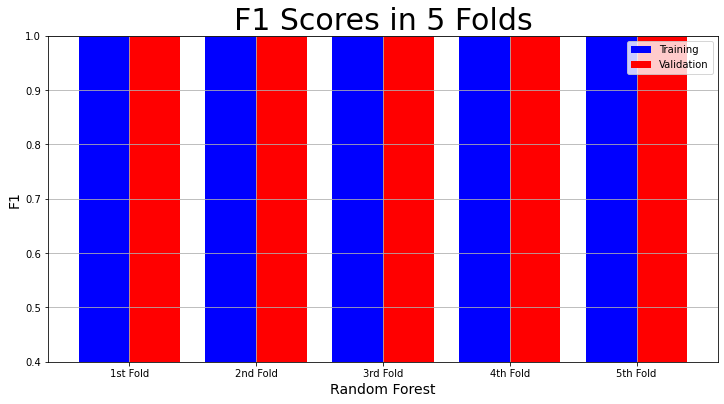

In [47]:
RFclassifier = RandomForestClassifier(criterion="entropy", min_samples_split=5, random_state=0)
RF_result = cross_validation(DCclassifier, X_train, y_train, 5)
model_name = "Random Forest"

# Plot Accuracy Result
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            RF_result["Training Accuracy scores"],
            RF_result["Validation Accuracy scores"])

# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            RF_result["Training Precision scores"],
            RF_result["Validation Precision scores"])

# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            RF_result["Training Recall scores"],
            RF_result["Validation Recall scores"])

# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            RF_result["Training F1 scores"],
            RF_result["Validation F1 scores"])

### Logistic Regression

In [48]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

# Accuracy
testScore = (logisticRegr.score(X_test, y_test))*100

print("ACCURACY ON TEST SET: {:.1f}%".format(testScore))

y_pred = logisticRegr.predict(X_test)

ACCURACY ON TEST SET: 83.3%


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Matrice di confusione

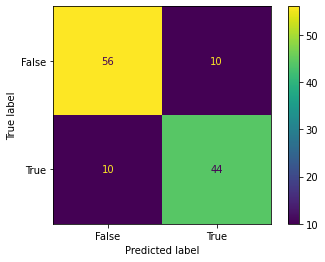

In [49]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

## Confronto risultati tra i due approcci utilizzati

##### L'approccio offline ha portato risultati sicuramente più affidabili in termini di accuratezza tuttavia è necessario sottolineare che l'approccio online è stato particolarmente compromesso dalla esigua dimensione del dataset (riscontrabile anche nel fatto che la cross-validation ha dato risultati molto variegati). Con un dataset più cospicuo e con un lavoro più preciso sulle feature, tramite il confronto con medici esperti, si potrebbe pertanto migliorare anche la qualità dell'approccio online.